In [1]:
# import dependencies 
import json
import pandas as pd
import numpy as np
import re

file_dir = 'C:/Users/tenle/Documents/GitHub/Movies_ETL/Resources/'

In [2]:
# Load th JSON into a List Dictionaries
with open(f'{file_dir}/wikipedia.movies.json', mode='r') as file:wiki_movies_raw = json.load(file)

In [3]:
# Add kaggle two dataframes into your project
kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}ratings.csv')

In [4]:
# list comprehension with the filter expression 
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie] 

In [5]:
# wiki_movies DataFrame.
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
wiki_movies_df.head()

url    year  \
0  https://en.wikipedia.org/wiki/The_Adventures_o...  1990.0   
1  https://en.wikipedia.org/wiki/After_Dark,_My_S...  1990.0   
2   https://en.wikipedia.org/wiki/Air_America_(film)  1990.0   
3    https://en.wikipedia.org/wiki/Alice_(1990_film)  1990.0   
4      https://en.wikipedia.org/wiki/Almost_an_Angel  1990.0   

                               imdb_link                            title  \
0  https://www.imdb.com/title/tt0098987/  The Adventures of Ford Fairlane   
1  https://www.imdb.com/title/tt0098994/             After Dark, My Sweet   
2  https://www.imdb.com/title/tt0099005/                      Air America   
3  https://www.imdb.com/title/tt0099012/                            Alice   
4  https://www.imdb.com/title/tt0099018/                  Almost an Angel   

          Directed by                  Produced by  \
0        Renny Harlin   [Steve Perry, Joel Silver]   
1         James Foley  [Ric Kidney, Robert Redlin]   
2  Roger Spottiswoode               Daniel Melnick   
3         Woody Allen              Robert Greenhut   
4        John Cornell                 John Cornell   

                                Screenplay by                     Story by  \
0  [David Arnott, James Cappe, Daniel Waters]  [David Arnott, James Cappe]   
1                [James Foley, Robert Redlin]                          NaN   
2                  [John Eskow, Richard Rush]                          NaN   
3                                         NaN                          NaN   
4                                         NaN                          NaN   

                                            Based on  \
0                        [Characters, by Rex Weiner]   
1  [the novel, After Dark, My Sweet, by, Jim Thom...   
2             [Air America, by, Christopher Robbins]   
3                                                NaN   
4                                                NaN   

                                            Starring  ... Predecessor  \
0  [Andrew Dice Clay, Wayne Newton, Priscilla Pre...  ...         NaN   
1  [Jason Patric, Rachel Ward, Bruce Dern, George...  ...         NaN   
2  [Mel Gibson, Robert Downey Jr., Nancy Travis, ...  ...         NaN   
3  [Alec Baldwin, Blythe Danner, Judy Davis, Mia ...  ...         NaN   
4        [Paul Hogan, Elias Koteas, Linda Kozlowski]  ...         NaN   

  Founders Area served Products Services Russian Hebrew Revenue  \
0      NaN         NaN      NaN      NaN     NaN    NaN     NaN   
1      NaN         NaN      NaN      NaN     NaN    NaN     NaN   
2      NaN         NaN      NaN      NaN     NaN    NaN     NaN   
3      NaN         NaN      NaN      NaN     NaN    NaN     NaN   
4      NaN         NaN      NaN      NaN     NaN    NaN     NaN   

  Operating income Polish  
0              NaN    NaN  
1              NaN    NaN  
2              NaN    NaN  
3              NaN    NaN  
4              NaN    NaN  

[5 rows x 193 columns]

# Create Function To Clean Data

In [6]:
# Function for cleaning movie data, use clean_movie

def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune-Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [7]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)

Since we’re going to be using the IMDb ID to merge with the Kaggle data, we want to make sure that we don’t have any duplicate rows, according to the IMDb ID. First, we need to extract the IMDb ID from the IMDb link

In [8]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))

# we only want to consider the IMDb ID, use the subset argument, and set inplace equal to "True
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True) # no copy of the object
print(len(wiki_movies_df))
wiki_movies_df.head()

7076
7033


url  year  \
0  https://en.wikipedia.org/wiki/The_Adventures_o...  1990   
1  https://en.wikipedia.org/wiki/After_Dark,_My_S...  1990   
2   https://en.wikipedia.org/wiki/Air_America_(film)  1990   
3    https://en.wikipedia.org/wiki/Alice_(1990_film)  1990   
4      https://en.wikipedia.org/wiki/Almost_an_Angel  1990   

                               imdb_link                            title  \
0  https://www.imdb.com/title/tt0098987/  The Adventures of Ford Fairlane   
1  https://www.imdb.com/title/tt0098994/             After Dark, My Sweet   
2  https://www.imdb.com/title/tt0099005/                      Air America   
3  https://www.imdb.com/title/tt0099012/                            Alice   
4  https://www.imdb.com/title/tt0099018/                  Almost an Angel   

                                            Based on  \
0                        [Characters, by Rex Weiner]   
1  [the novel, After Dark, My Sweet, by, Jim Thom...   
2             [Air America, by, Christopher Robbins]   
3                                                NaN   
4                                                NaN   

                                            Starring         Narrated by  \
0  [Andrew Dice Clay, Wayne Newton, Priscilla Pre...  Andrew "Dice" Clay   
1  [Jason Patric, Rachel Ward, Bruce Dern, George...                 NaN   
2  [Mel Gibson, Robert Downey Jr., Nancy Travis, ...                 NaN   
3  [Alec Baldwin, Blythe Danner, Judy Davis, Mia ...                 NaN   
4        [Paul Hogan, Elias Koteas, Linda Kozlowski]                 NaN   

   Cinematography                                       Release date  \
0     Oliver Wood                  [July 11, 1990, (, 1990-07-11, )]   
1    Mark Plummer  [May 17, 1990, (, 1990-05-17, ), (Cannes Film ...   
2   Roger Deakins                [August 10, 1990, (, 1990-08-10, )]   
3  Carlo Di Palma              [December 25, 1990, (, 1990-12-25, )]   
4    Russell Boyd                                  December 19, 1990   

  Running time  ... Preceded by Suggested by alt_titles Recorded Venue Label  \
0  102 minutes  ...         NaN          NaN        NaN      NaN   NaN   NaN   
1  114 minutes  ...         NaN          NaN        NaN      NaN   NaN   NaN   
2  113 minutes  ...         NaN          NaN        NaN      NaN   NaN   NaN   
3  106 minutes  ...         NaN          NaN        NaN      NaN   NaN   NaN   
4   95 minutes  ...         NaN          NaN        NaN      NaN   NaN   NaN   

  Animation by Color process McCune–Reischauer    imdb_id  
0          NaN           NaN               NaN  tt0098987  
1          NaN           NaN               NaN  tt0098994  
2          NaN           NaN               NaN  tt0099005  
3          NaN           NaN               NaN  tt0099012  
4          NaN           NaN               NaN  tt0099018  

[5 rows x 41 columns]

In [9]:
# Remove null columns
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [10]:
wiki_movies_df.head()

url  year  \
0  https://en.wikipedia.org/wiki/The_Adventures_o...  1990   
1  https://en.wikipedia.org/wiki/After_Dark,_My_S...  1990   
2   https://en.wikipedia.org/wiki/Air_America_(film)  1990   
3    https://en.wikipedia.org/wiki/Alice_(1990_film)  1990   
4      https://en.wikipedia.org/wiki/Almost_an_Angel  1990   

                               imdb_link                            title  \
0  https://www.imdb.com/title/tt0098987/  The Adventures of Ford Fairlane   
1  https://www.imdb.com/title/tt0098994/             After Dark, My Sweet   
2  https://www.imdb.com/title/tt0099005/                      Air America   
3  https://www.imdb.com/title/tt0099012/                            Alice   
4  https://www.imdb.com/title/tt0099018/                  Almost an Angel   

                                            Based on  \
0                        [Characters, by Rex Weiner]   
1  [the novel, After Dark, My Sweet, by, Jim Thom...   
2             [Air America, by, Christopher Robbins]   
3                                                NaN   
4                                                NaN   

                                            Starring  Cinematography  \
0  [Andrew Dice Clay, Wayne Newton, Priscilla Pre...     Oliver Wood   
1  [Jason Patric, Rachel Ward, Bruce Dern, George...    Mark Plummer   
2  [Mel Gibson, Robert Downey Jr., Nancy Travis, ...   Roger Deakins   
3  [Alec Baldwin, Blythe Danner, Judy Davis, Mia ...  Carlo Di Palma   
4        [Paul Hogan, Elias Koteas, Linda Kozlowski]    Russell Boyd   

                                        Release date Running time  \
0                  [July 11, 1990, (, 1990-07-11, )]  102 minutes   
1  [May 17, 1990, (, 1990-05-17, ), (Cannes Film ...  114 minutes   
2                [August 10, 1990, (, 1990-08-10, )]  113 minutes   
3              [December 25, 1990, (, 1990-12-25, )]  106 minutes   
4                                  December 19, 1990   95 minutes   

         Country  ...       Budget        Box office            Director  \
0  United States  ...  $20 million     $21.4 million        Renny Harlin   
1  United States  ...   $6 million      $2.7 million         James Foley   
2  United States  ...  $35 million       $57,718,089  Roger Spottiswoode   
3  United States  ...  $12 million        $7,331,647         Woody Allen   
4             US  ...  $25 million  $6,939,946 (USA)        John Cornell   

          Distributor                       Editor(s)  \
0    20th Century Fox                 Michael Tronick   
1     Avenue Pictures                 Howard E. Smith   
2    TriStar Pictures  [John Bloom, Lois Freeman-Fox]   
3      Orion Pictures                  Susan E. Morse   
4  Paramount Pictures                    David Stiven   

               Composer(s)                  Producer(s)  \
0  [Cliff Eidelman, Yello]   [Steve Perry, Joel Silver]   
1            Maurice Jarre  [Ric Kidney, Robert Redlin]   
2            Charles Gross               Daniel Melnick   
3                      NaN              Robert Greenhut   
4            Maurice Jarre                 John Cornell   

                   Production company(s)                     Writer(s)  \
0                        Silver Pictures   [David Arnott, James Cappe]   
1                        Avenue Pictures  [James Foley, Robert Redlin]   
2  [Carolco Pictures, IndieProd Company]    [John Eskow, Richard Rush]   
3                                    NaN                   Woody Allen   
4                                    NaN                    Paul Hogan   

     imdb_id  
0  tt0098987  
1  tt0098994  
2  tt0099005  
3  tt0099012  
4  tt0099018  

[5 rows x 21 columns]

Make a Plan to Convert and Parse the Data

In [11]:
# first we’ll make a data series that drops missing values, start with box office
box_office = wiki_movies_df['Box office'].dropna() 

In [12]:
# second we’ll need to make sure all of the box office data is entered as a string.
# create a function is_not_a_string to return a value !=str
def is_not_a_string(x):
    return type(x) != str


In [13]:
# add the string function
box_office[box_office.map(is_not_a_string)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [14]:
# Use lambdafunction to ensure all of the box office data is entered as a string
box_office[box_office.map(lambda x: type(x) != str)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [15]:
# Use join() string method to remove the data points that are stored as lists
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)
box_office.head()

0       $21.4 million
1        $2.7 million
2         $57,718,089
3          $7,331,647
4    $6,939,946 (USA)
Name: Box office, dtype: object

Remember, there are two main forms the box office data is written in: “$123.4 million” (or billion), and “$123,456,789.” 
We’re going to build a regular expression for each form, and then see what forms are left over.

In [16]:
# Preface the string with an r for the escape characters to remain.
form_one = r'\$\d+\.?\d*\s*[mb]illion'

In [17]:
# Preface the string with an r for the escape characters to remain.
form_two = r'\$\d{1,3}(?:,\d{3})+'

In [18]:
# Create two Boolean Series called matches_form_one and matches_form_two
import re
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE)
box_office[matches_form_one & matches_form_two]

4930      $36.1 million [1] $8,610,119 (US DVD sales) [3]
6358    $18,687,388 (Theatrical Performance) [4] $1,26...
Name: Box office, dtype: object

In [19]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'

In [20]:
# Change form_two to allow for either a comma or period as a thousands separator
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

In [21]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

Use the expressions to extract only the parts of the strings that match

In [22]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

First, we need to extract the values from box_office using str.extract. Then we'll apply parse_dollars to the first column in the DataFrame returned by str.extract, which in code looks like the following:

In [23]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [24]:
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [25]:
budget = wiki_movies_df['Budget'].dropna()

In [26]:
# Convert any lists to strings:
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [27]:
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [28]:
# Create two Boolean Series called matches_form_one and matches_form_two, 
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973             $34 [3] [4] million
1126               $120 [4] million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360               $150 [6] million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034              $$200 [4] million
5055           $155 [2] [3] million
5419                $40 [4] 

In [29]:
# remove  citations  references
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973                     $34 million
1126                   $120 million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360                   $150 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034                  $$200 million
5055                   $155 million
5419                    $40 

In [30]:
# Parse the budget values
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [31]:
# Drop  Budget column.
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [32]:
# Release date variable using lambda
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

The forms we’ll be parsing are:

    Full month name, one- to two-digit day, four-digit year (i.e., January 1, 2000)
    Four-digit year, two-digit month, two-digit day, with any separator (i.e., 2000-01-01)
    Full month name, four-digit year (i.e., January 2000)
    Four-digit year


In [33]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [34]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

Parse Running Time
First, make a variable that holds the non-null values of Release date in the DataFrame, converting lists to strings

In [35]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [36]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [37]:
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

Now we can apply a function that will convert the hour capture groups and minute capture groups to minutes if the pure minutes capture group is zero, and save the output to wiki_movies_df:

In [38]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [39]:
# Drop Running time from the dataset with the following code:
wiki_movies_df.drop('Running time', axis=1, inplace=True)

Clean Kaggle Data

In [40]:
kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [41]:
# Check values are either True or False.
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [42]:
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

adult  \
19730                                 - Written by Ørnås   
29503   Rune Balot goes to a casino connected to the ...   
35587   Avalanche Sharks tells the story of a bikini ...   

      belongs_to_collection                            budget  \
19730              0.065736  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29503              1.931659  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35587              2.185485  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                  genres  \
19730  [{'name': 'Carousel Productions', 'id': 11176}...   
29503  [{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...   
35587  [{'name': 'Odyssey Media', 'id': 17161}, {'nam...   

                                                homepage          id imdb_id  \
19730  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...  1997-08-20       0   
29503  [{'iso_3166_1': 'US', 'name': 'United States o...  2012-09-29       0   
35587           [{'iso_3166_1': 'CA', 'name': 'Canada'}]  2014-01-01       0   

      original_language                            original_title  overview  \
19730             104.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
29503              68.0      [{'iso_639_1': 'ja', 'name': '日本語'}]  Released   
35587              82.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

       ... release_date revenue runtime spoken_languages status  tagline  \
19730  ...            1     NaN     NaN              NaN    NaN      NaN   
29503  ...           12     NaN     NaN              NaN    NaN      NaN   
35587  ...           22     NaN     NaN              NaN    NaN      NaN   

       title video vote_average vote_count  
19730    NaN   NaN          NaN        NaN  
29503    NaN   NaN          NaN        NaN  
35587    NaN   NaN          NaN        NaN  

[3 rows x 24 columns]

In [43]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [44]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [45]:
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [46]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [47]:
# Convert release_date to to_datetime().
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [48]:
# Assign it to the timestamp column.
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [85]:
# Merge  IMDb ID.
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])

In [86]:
movies_df.columns

Index(['url', 'year', 'imdb_link', 'title_wiki', 'Based on', 'Starring',
       'Cinematography', 'Release date', 'Country', 'Language', 'Director',
       'Distributor', 'Editor(s)', 'Composer(s)', 'Producer(s)',
       'Production company(s)', 'Writer(s)', 'imdb_id', 'box_office',
       'budget_wiki', 'release_date_wiki', 'running_time',
       'belongs_to_collection', 'budget_kaggle', 'genres', 'homepage', 'id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date_kaggle', 'revenue', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title_kaggle', 'video', 'vote_average',
       'vote_count'],
      dtype='object')

# Assumption: 
As shown in the data above, it is inidcated the there are 7 instances of similar data from Wiki and MovieLens

- Similar Data from  Wiki and MovieLens
- box_office : revenue
- release_date_wiki : release_data_kaggle
- title_wiki : title_kaggle
- budget_wiki : budget_kaggle
- Production company(s) : production_companies
- running_time : runtime
- Language : originale_language


In [87]:
# Drop the title_wiki, release_date_wiki, Language, and Production company(s) columns.
movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)

In [91]:
# Create a function that fills missing data and drop redundant column.
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
        , axis=1)
    df.drop(columns=wiki_column, inplace=True)

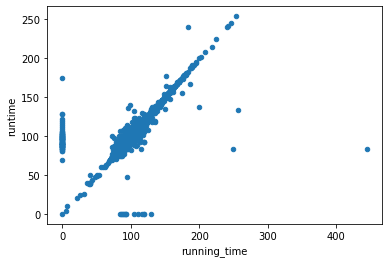

In [95]:
movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')

# Assumption
# Create a function that fills missing data and drop redundant column.
As shown in the data above:
- As shown in the data above the running_time vs the runtime, it was observed that the runtimes are very close together with the Wiki data having outliers
- Wikipedia data has more outliers in comparison to the Kaggle data
- Some Kaggle movie have 0 runtime where Wiki has data.


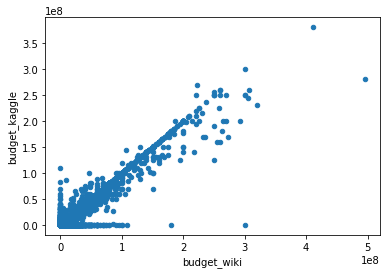

In [105]:
movies_df.fillna(0).plot(x='budget_wiki',y='budget_kaggle', kind='scatter')

# Assumption
As shown in the data above:
- The budget_wiki data  have more outliers compared to the budget_kaggle data. 
- There are movies with no data in the Kaggle column, and wiki has budget data. 